# *Brewing* SMA and RSI

#### Agenda: 

Previously, we explored the *field* of sma crossovers of JPYUSD. The resulting heatmap suggests that a region of higher returns exists within the 3D space (cross_1, cross_2, return_of_crossovers) of two 1 to 180 time-units crossovers. 
The aim of this notebook is to further our exploration by *brewing* an SMA crossover from the region of higher returns with a fine-tuned RSI indicator. The main question we will try to answer in this notebook is whether the *brewing* of two indicators, fine-tuned with the best-performing parameters for a given financial asset (JPYUSD), results in higher returns with lesser risk. 

Let's import a module *FinancialInstrument* that contains 4 classes:

* DATA                 # for data retrieval via yfinance.
* SMA_Backtester       # for finding and testing best performing SMA crossover.
* RSI_tester           # for finding and testing the best performing RSI period.
* SMA_RSI_tester       # for testing the best SMA crossover brewed with best RSI

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
plt.style.use("seaborn")
import talib as ta
from talib import abstract
import seaborn as sns


class FinancialInstrument():
    def __init__(self):
        self.df = None
        
    class DATA: 
        def __init__(self, ticker, main= FinancialInstrument):
            self.main = main
            self.ticker = ticker
            self.start = datetime.datetime(2006,6,1) 
            self.end = datetime.datetime.today()
            self.data = None

        def get_data(self):
            ''' retrieves (from yahoo finance) and prepares the data
            '''
            raw = yf.download(self.ticker, self.start, self.end)
            raw.rename(columns = {"Close":"price", "Volume":"volume", "Open":"open", "High":"high", 
                                 "Adj Close":"close", "Low":"low"}, inplace = True)
            raw["returns"] = (raw.price - raw.price.shift(1)) / raw.price.shift(1)
            raw["log_returns"] = np.log(raw.price/raw.price.shift(1))
            self.data = raw
            self.main.df = raw
            return self.data
                 
        def plot_prices(self):
            ''' creates a price chart
            '''
            plt.figure(figsize=(16,6))
            self.data.price.plot(figsize = (17,8), color = "black", label = "Close price")
            plt.title("Price Chart: {}".format(self.ticker), fontsize = 15)
            plt.grid()
            plt.legend();
            
        def change_ticker(self, ticker = None):
            '''sets a new ticker
            '''
            if ticker is not None:
                self.ticker = ticker
                self.get_data()

############## Simple MA backtester : class SMA ##############################

    class SMA_Backtester():
        def __init__(self, main = FinancialInstrument):
            self.main = main
            self.df =  self.main.df
            self.results = None

        def set_parameters(self, SMA_S = None, SMA_L = None):
            ''' Updates SMA parameters and the prepared dataset.
            '''
            if SMA_S is not None:
                self.SMA_S = SMA_S
                self.df["SMA_S"] = self.df["price"].rolling(self.SMA_S).mean()
            if SMA_L is not None:
                self.SMA_L = SMA_L
                self.df["SMA_L"] = self.df["price"].rolling(self.SMA_L).mean()

        def test_strategy(self, plot = None):
            ''' Backtests the SMA-based trading strategy.
            '''
            self.data = self.df.copy().dropna()
            self.data["SMA_position"] = np.where(self.data["SMA_S"] > self.data["SMA_L"], 1, -1)
            self.data["SMA_strategy"] = self.data["SMA_position"].shift(1) * self.data["returns"]
            self.data.dropna(inplace=True)
            self.data["creturns"] = self.data["returns"].cumsum().apply(np.exp)
            self.data["SMA_cstrategy"] = self.data["SMA_strategy"].cumsum().apply(np.exp)
            self.results = self.data
            self.main.df = self.data
            
            perf = self.data["SMA_cstrategy"].iloc[-1] # absolute performance of the strategy
            outperf = perf - self.data["creturns"].iloc[-1] # out-/underperformance of strategy
            if self.results is None:
                print("Run test_strategy() first.")
            elif plot == True:
                title = " | SMA_S = {} | SMA_L = {}, PERF = {}, OUTPERF = {}".format( self.SMA_S, self.SMA_L, round(perf, 6), round(outperf, 6))
                self.results[["creturns", "SMA_cstrategy"]].plot(title=title, figsize=(17, 8), color = ["black", "blue"])
            else:
                return round(perf, 6), round(outperf, 6)

        def plot_results(self):
            ''' Plots the performance of the trading strategy and compares to "buy and hold".
            '''
            if self.results is None:
                print("Run test_strategy() first.")
            elif plot == True:
                title = " | SMA_S = {} | SMA_L = {}".format( self.SMA_S, self.SMA_L)
                self.results[["creturns", "SMA_cstrategy"]].plot(title=title, figsize=(17, 8), color = ["black","blue"])
            else:
                pass

        def plot_field(self):
            ''' Plots the heatmap of performance of the trading strategy".
            '''
            if self.results is None:
                print("Run optimize_parameters() first.")
            else:
                sns.set(rc={'figure.figsize':(22,22)})
                df_wide = self.results_overview.pivot_table( index='SMA_L', columns='SMA_S', values='SMA_performance')
                sns.heatmap(df_wide);


        def optimize_parameters(self, SMA_S_range, SMA_L_range):
            ''' Finds the optimal strategy (global maximum) given the SMA parameter ranges.

            Parameters
            ----------
            SMA_S_range, SMA_L_range: tuple
                tuples of the form (start, end, step size)
            '''
            combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))

            # test all combinations
            results = []
            for comb in combinations:
                self.set_parameters(comb[0], comb[1])
                results.append(self.test_strategy()[0])

            best_perf = np.max(results) # best performance
            opt = combinations[np.argmax(results)] # optimal parameters

            # run/set the optimal strategy
            self.set_parameters(opt[0], opt[1])
            self.test_strategy()

            # create a df with many results
            many_results =  pd.DataFrame(data = combinations, columns = ["SMA_S", "SMA_L"])
            many_results["SMA_performance"] = results
            self.results_overview = many_results

            return opt, best_perf

    class RSI_tester():

        ''' Class for the vectorized backtesting of SMA-based trading strategies.
        '''

        def __init__(self,   main = FinancialInstrument):
            self.main = main
            self.df =  self.main.df            
            self.rsi = None
            self.results = None 
            #self.df["RSI"] = ta.RSI(self.df["price"], self.rsi)


        def set_parameters(self, rsi = None):
            ''' Updates RSI parameters and the prepared dataset.
            '''
            if rsi is not None:
                self.rsi = rsi
                self.df["RSI"] = abstract.RSI(self.df, self.rsi) 

        def test_strategy(self, plot = None):
            ''' Backtests the RSI-based trading strategy.
            '''
            data = self.df.copy().dropna()
            data["RSI_position"] = np.where(data["RSI"] < 20, 1, np.nan)
            data["RSI_position"] = np.where(data["RSI"] > 90, -1, data["RSI_position"])
            data["RSI_position"] = data["RSI_position"].fillna(0)

            data["RSI_strategy"] = data["RSI_position"].shift(1) * data["returns"]
            data.dropna(inplace=True)
            data["creturns"] = data["returns"].cumsum().apply(np.exp)
            data["RSI_cstrategy"] = data["RSI_strategy"].cumsum().apply(np.exp)
            self.results = data
            self.main.df  = data
           # return self.main.df
            perf = data["RSI_cstrategy"].iloc[-1] # absolute performance of the strategy
            outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
            if plot == True:
                title = "RSI {} | PERF:{} | OUTPERF:{}".format(self.rsi, round(perf, 6), round(outperf, 6))
                self.results[["creturns", "RSI_cstrategy"]].plot(title=title, figsize=(17, 8), color = ["black", "red"])
            else: 
                return round(perf, 6), round(outperf, 6)


        def optimize_parameters(self, a,b):
            ''' Finds the optimal strategy (global maximum) given the RSI parameter ranges.
            '''  
            combinations = list(range(a,b))

            # test all combinations
            results = []
            self.data = self.df.copy().dropna()
            
            
            for comb in range(a,b):
                self.set_parameters(comb)
                results.append(self.test_strategy()[0])


            best_perf = np.max(results) # best performance
            opt = combinations[np.argmax(results)] # optimal parameters

            # run/set the optimal strategy
            self.set_parameters(opt)
            self.test_strategy()

            # create a df with many results
            many_results =  pd.DataFrame(data = combinations, columns = ["RSI"])
            many_results["RSI_performance"] = results
            self.results_overview = many_results

            return round(opt,6), round(best_perf,6) 

    class SMA_RSI_tester():

            ''' Class for the vectorized backtesting of SMA-based trading strategies.
            '''

            def __init__(self,  main = FinancialInstrument):
                self.main = main
                self.data =  self.main.df 
                self.results = None 
                
            def test_strategy(self, plot = None):
                ''' Backtests the RSI-based trading strategy.
                '''
                data = self.data.copy().dropna()
                data["SMA_RSI_position"] = np.where((data["RSI_position"] == 1) & data["SMA_position"]==1, 1, np.nan)
                data["SMA_RSI_position"] = np.where((data["RSI_position"] == -1) & data["SMA_position"]==-1, -1, data["SMA_RSI_position"])
                data["SMA_RSI_position"] = data["SMA_RSI_position"].fillna(0)

                data["SMA_RSI_strategy"] = data["SMA_RSI_position"].shift(1) * data["returns"]
                data.dropna(inplace=True)
                data["creturns"] = data["returns"].cumsum().apply(np.exp)
                data["SMA_RSI_cstrategy"] = data["SMA_RSI_strategy"].cumsum().apply(np.exp)
                self.results = data
                self.main.df  = data
                
                perf = data["SMA_RSI_cstrategy"].iloc[-1] # absolute performance of the strategy
                outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
                if plot == True:
                   # title = "perf {} | RSI{} | outperf = {}".format(round(perf, 6), self.rsi, round(outperf, 6))
                    self.results[["creturns", "SMA_RSI_cstrategy"]].plot(title="Placeholder",  figsize=(17, 8), color = ["black", "green"])

                return round(perf, 6), round(outperf, 6)



### Loading Data

In [205]:
inst = FinancialInstrument()

In [206]:
# data download 
rab = inst.DATA("USDJPY=X")
df = rab.get_data()
df

[*********************100%***********************]  1 of 1 completed


,open,high,low,price,close,volume,returns,log_returns
Date,,,,,,,,
2006-05-31,112.144997,112.660004,111.550003,112.529999,112.529999,0,NaN,NaN
2006-06-01,112.550003,113.330002,112.370003,112.480003,112.480003,0,-0.000444,-0.000444
2006-06-02,112.470001,112.910004,111.339996,111.730003,111.730003,0,-0.006668,-0.006690
2006-06-05,111.629997,112.339996,111.500000,112.339996,112.339996,0,0.005460,0.005445
2006-06-06,112.349998,113.510002,112.070000,113.214996,113.214996,0,0.007789,0.007759
...,...,...,...,...,...,...,...,...
2023-01-05,132.246002,133.992004,131.729996,132.246002,132.246002,0,0.007604,0.007575
2023-01-06,133.307007,134.740997,132.186996,133.307007,133.307007,0,0.008023,0.007991
2023-01-09,131.862000,132.645004,131.326996,131.862000,131.862000,0,-0.010840,-0.010899


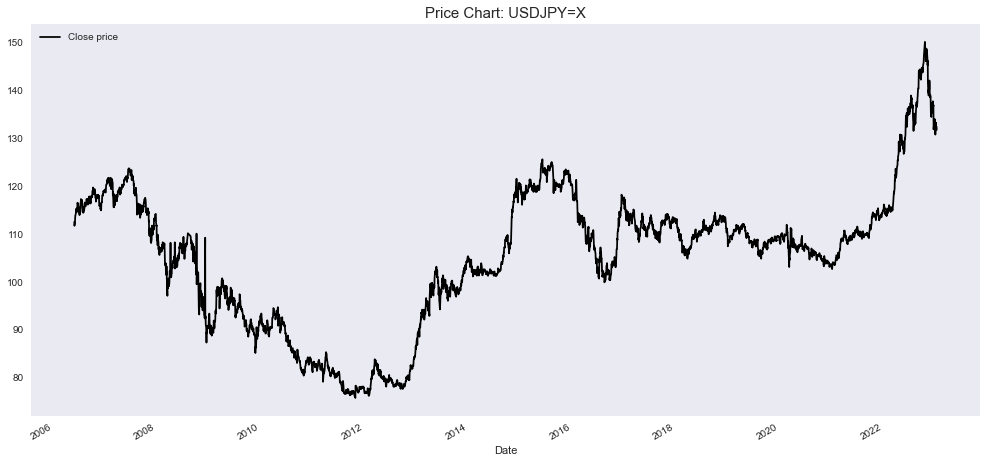

In [207]:
# Let's plot the Close prices:

rab.plot_prices()

### Finding the best SMA crossover 

In [208]:
# Let's create an instance of a SMA Backtester:

sma_tester = inst.SMA_Backtester()

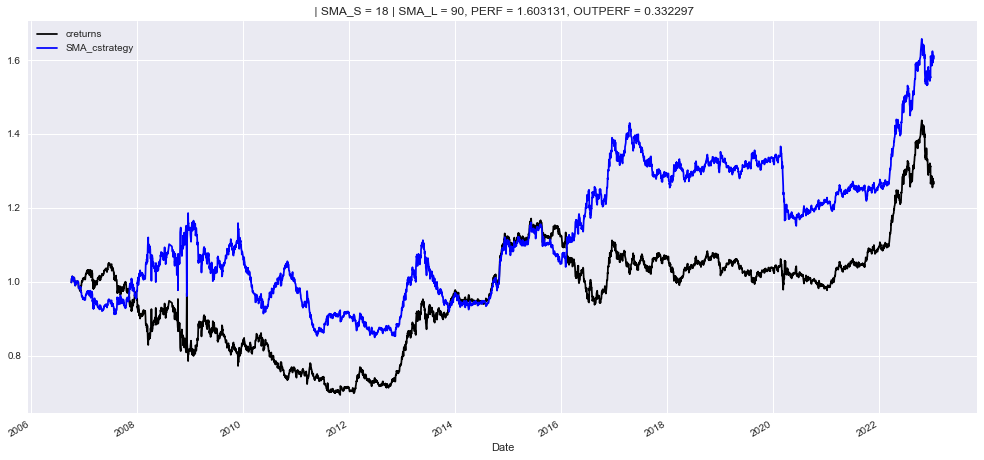

In [209]:
# Let's set random parameters of two SMA windows and then plot the result:

sma_tester.set_parameters(18,90)

sma_tester.test_strategy(plot = True)

Now let's find the best performing crossover (high returns) of two SMAs bt 10 to 200. 

In [54]:
sma_tester.optimize_parameters((10,200), (10,200))

((42, 43), 3.177745)

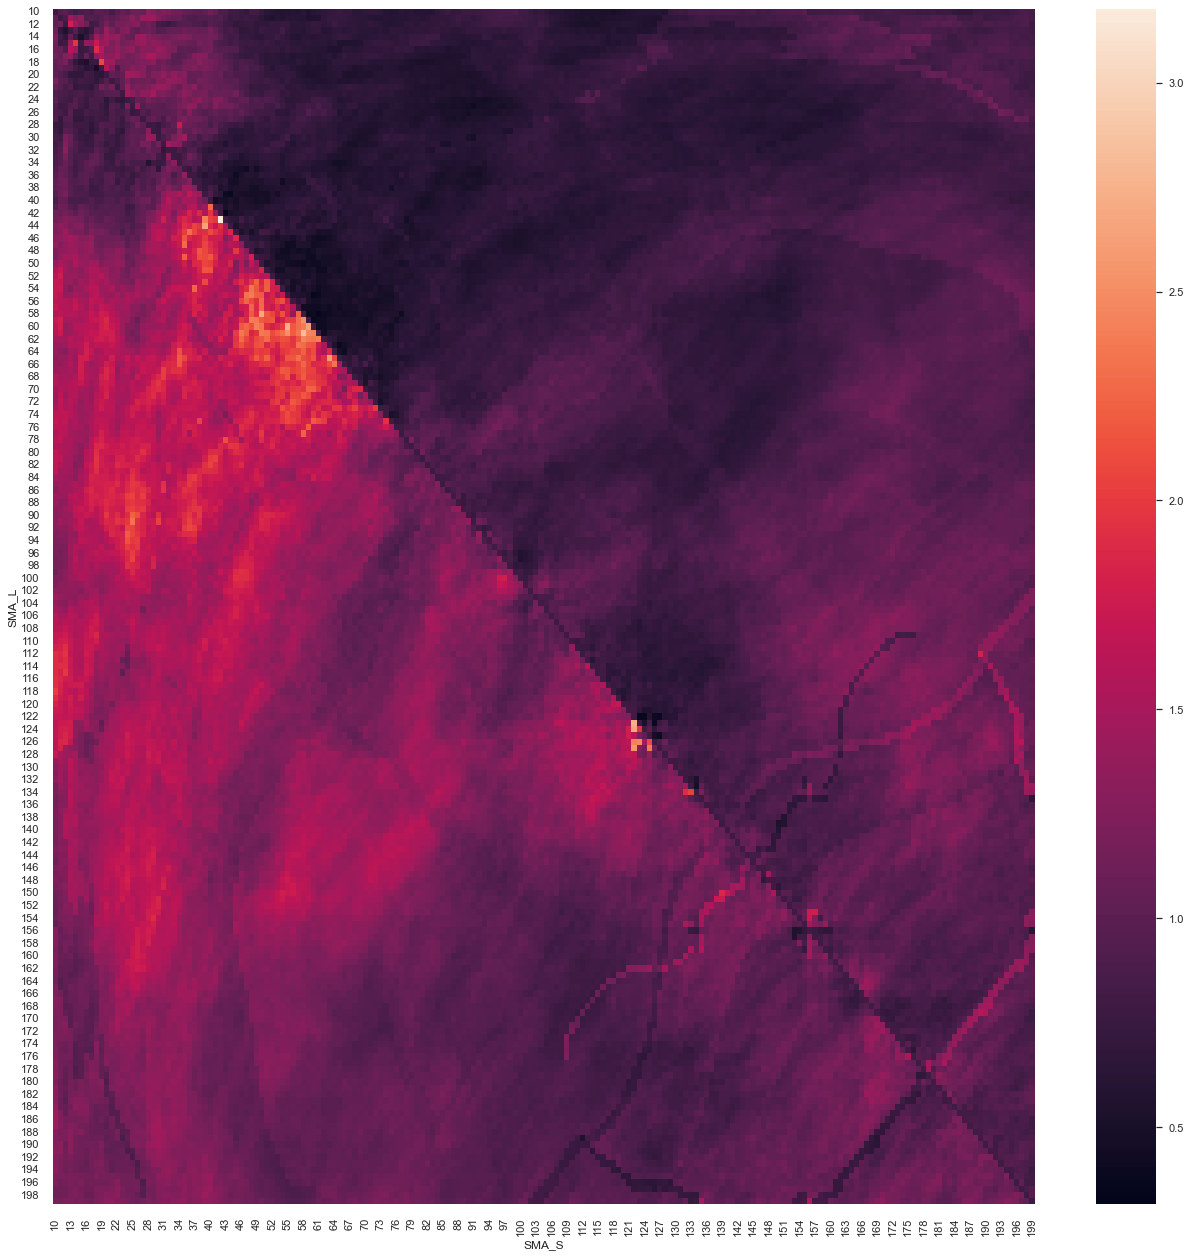

In [56]:
sma_tester.plot_field()

In [57]:
sma_tester.results_overview.nlargest(10, 'SMA_performance')

,SMA_S,SMA_L,SMA_performance
6113,42,43,3.177745
9171,58,61,2.839349
8600,55,60,2.741648
21393,122,123,2.735602
7648,50,58,2.681556
21394,122,124,2.668191
5544,39,44,2.645509
9360,59,60,2.635506
10125,63,65,2.602791
21397,122,127,2.573350


The best performing SMA crossover is 42X43 but closer examination of the heatmap reveals that the region of the 42X43 has lesser intensity of returns when compared to the region around ≈50X≈65. The table of the best performing crossovers confirms this finding: 6 out of 10 best performing crossovers come from the region ≈50X≈65, and only 2 crossovers come from the ≈40X≈40.


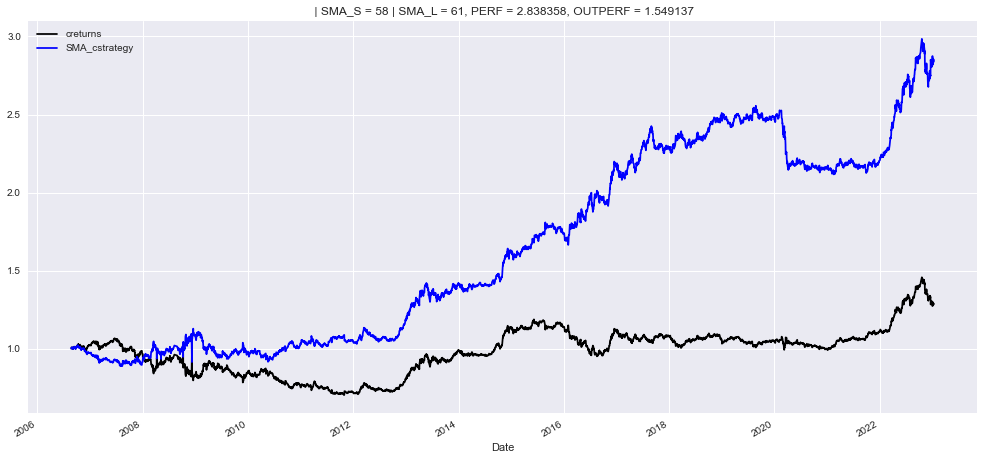

In [210]:
# Loading our data with the best performing parameters (second place in the table above):

sma_tester.set_parameters(58,61)
sma_tester.test_strategy(plot=True)

### Finding the best RSI window.

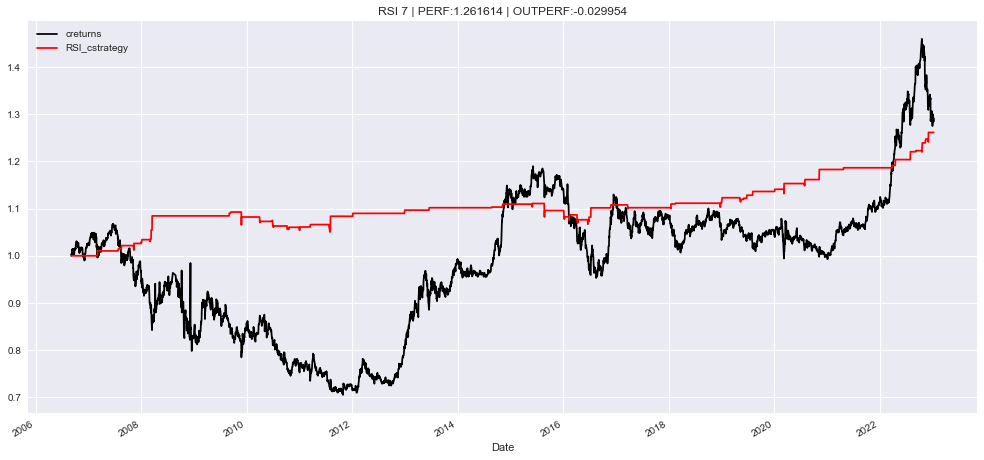

In [211]:
# Let's instantiate the RSI_tester

rsi = inst.RSI_tester()

#  and load it with a randomly chosen window size (7)

rsi.set_parameters(7)

# Ploting the results

rsi.test_strategy(plot = True)

Let's optimize the RSI by scanning windows of lenght 2 to 20

In [212]:
rsi.optimize_parameters(2,20)

(2, 2.431959)

Our best performing RSI window is 2 (days, in our case) with creturns of 2.41. Let's see how it looks like on the plot:

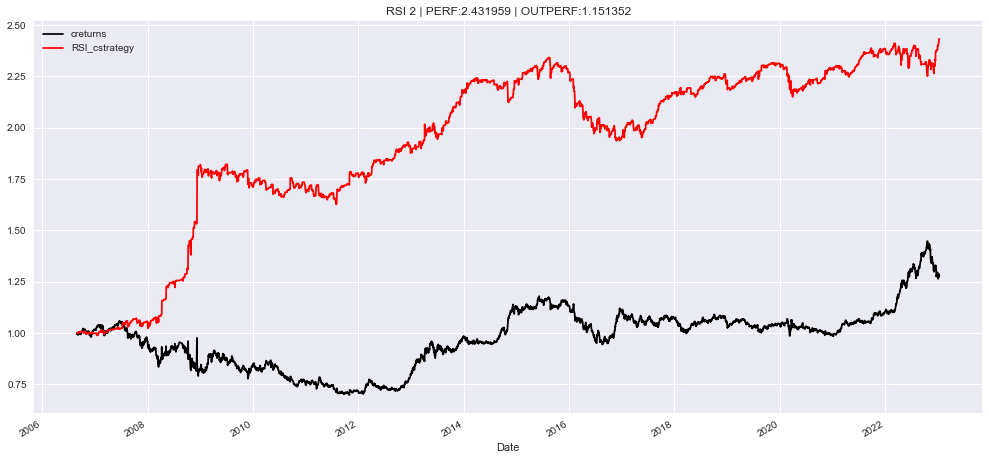

In [213]:
rsi.test_strategy(plot = True)

Let's plot the best RSI, best SMA and the regular buy and hold returns:

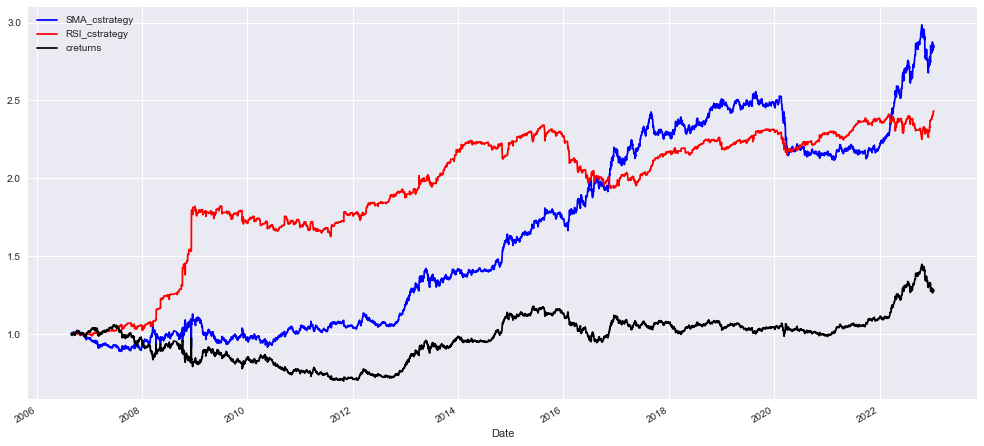

In [214]:
df = rsi.results
df[["SMA_cstrategy", "RSI_cstrategy", "creturns"]].plot(figsize = (17,8), color = [ "blue", "red","black"]);

The plot above demonstrates the performance of the fine-tuned SMA and RSI strategies for the asset USDJPY. Both strategies significantly outperform buy and hold (which is not recomended strategy in the forex market). 
na). 

One of the major problems with these strategies is the excess trading. Especially in RSI, where the best performing time window is 2 (days).
Our next step will try to (partialy) reduce the number of open positions. To open long or short position in the combined SMA-RSI strategy we will need to have confirmation from both fine-tuned indicators.   

In [215]:
smarsi = inst.SMA_RSI_tester()

(2.095573, 0.809873)

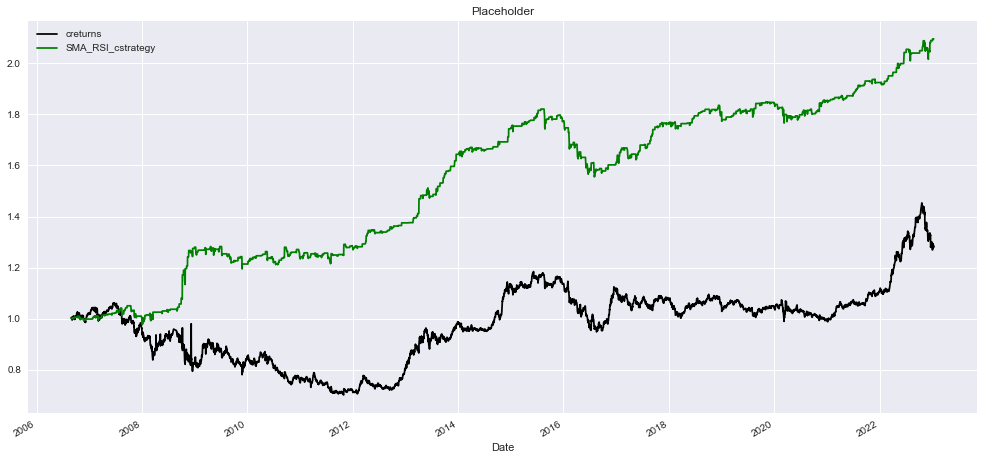

In [217]:
smarsi.test_strategy(plot = True)

Let's plot all 3 together (SMA, RSI, and SMA_RSI)

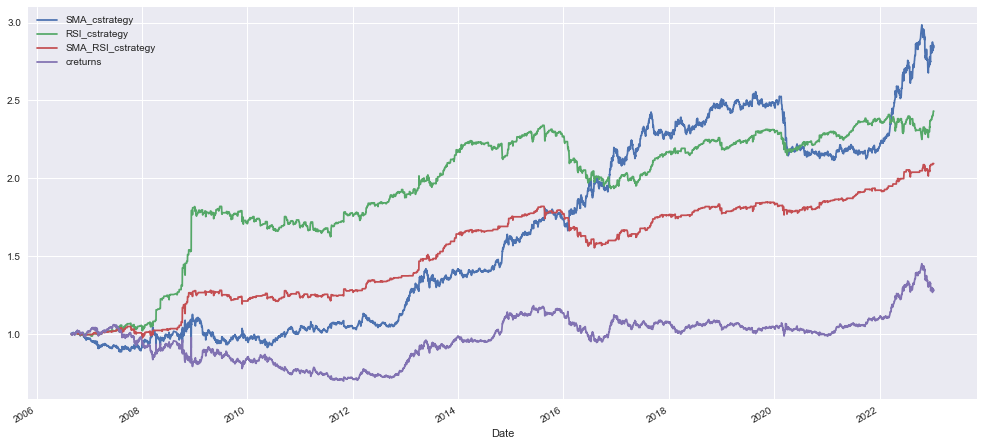

In [218]:
smarsi.results[["SMA_cstrategy", "RSI_cstrategy", "SMA_RSI_cstrategy", "creturns"]].plot(figsize = (17,8));

The SMA_RSI strategy outperforms buy and hold by unsatisfactory 80%, let's see if we managed to lower the risk:

In [227]:
std_sma =  smarsi.results["SMA_cstrategy"].std()
std_rsi =  smarsi.results["RSI_cstrategy"].std()
std_sma_rsi =  smarsi.results["SMA_RSI_cstrategy"].std()
std_buy_hold =  smarsi.results["creturns"].std()

df = pd.DataFrame({"STD": [std_sma,std_rsi,std_sma_rsi, std_buy_hold], "STRATEGY": ["SMA", "RSI", "SMA-RSI", "BUY & HOLD"]})

df.sort_values("STD")

,STD,STRATEGY
3,0.144636,BUY & HOLD
2,0.309513,SMA-RSI
1,0.395198,RSI
0,0.610589,SMA


Indeed, our STD is the lowest of the three. 